In [28]:
from pix2tree import valid
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import datetime
import numpy as np
import os

from utils.tree import Tree, tree_similarity
from dataset import Pix2TreeDataset
from utils.transforms import Rescale, WordEmbedding, TreeToTensor, Vec2Word
from models import BatchModel
from utils.generator import Env

import matplotlib.pyplot as plt

# Arguments

In [64]:
with_rule = False           # Predict with rules?
img_dir = './dataset/img'   # directory of images
tree_dir = './dataset/xml'  # directory of trees
pred_trees_file = './predict/predXrule.npy'

In [65]:
pred_trees = np.load(pred_trees_file, allow_pickle=True)

In [13]:
def count_word_dict(dataset):
    word_count = {'root':0, 'end':0}
    def count_tree(tree, word_count):
        for child in tree.children:
            count_tree(child, word_count)
        if tree.value in word_count:
            word_count[tree.value] += 1
        else:
            word_count[tree.value] = 1

    for i in range(len(dataset)):
        count_tree(dataset[i]['tree'], word_count)

    word_dict = {}
    i = 0
    for key in word_count.keys():
        a = np.zeros(len(word_count))
        a[i] = 1.0
        word_dict[key] = a
        i += 1
    return word_dict

dataset = Pix2TreeDataset(img_dir=img_dir,tree_dir=tree_dir)
if not os.path.exists('word_dict.npy'):
    word_dict = count_word_dict(dataset)
    np.save('word_dict.npy', word_dict)
else:
    word_dict = np.load('word_dict.npy', allow_pickle=True).item()

In [14]:
valid_data = Pix2TreeDataset(
            partition=range(int(len(dataset)*0.8), len(dataset)),
            img_transform=transforms.Compose([Rescale(224),
                                              transforms.ToTensor()]),img_dir=img_dir,tree_dir=tree_dir)

In [16]:
scores = []
for i in range(len(valid_data)):
    score = tree_similarity(pred_trees[i], valid_data[i]['tree'])
    scores.append(score)

In [32]:
print('average={}\n\rmax={}\n\rmid={}\n\rmin={}\n\rvariance={}'.format(np.average(scores),np.max(scores),np.median(scores),np.min(scores),np.var(scores)))

average=0.6444873740362891
max=0.9134630328204693
mid=0.709465558469081
min=0.12719813892988469
variance=0.025830842978188013


## Histagram of Score

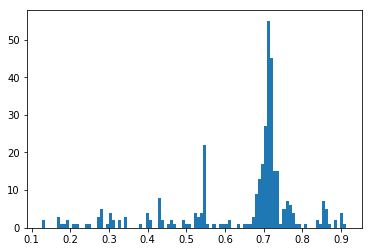

In [61]:
_ = plt.hist(scores,100)

# Histagram of Length
----

## pred

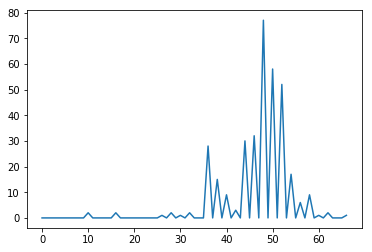

In [58]:
lengths = [pred_trees[i].size() for i in range(len(pred_trees))]
lengths_hist = [0 for i in range(np.max(lengths)+1)]

for length in lengths :
    lengths_hist[length]+=1
_ = plt.plot(lengths_hist)

## test

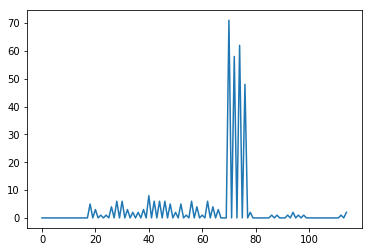

In [59]:
lengths = [valid_data[i]['tree'].size() for i in range(len(pred_trees))]
lengths_hist = [0 for i in range(np.max(lengths)+1)]

for length in lengths :
    lengths_hist[length]+=1
_ = plt.plot(lengths_hist)